# Are graph embeddings continuous? (Embedding by random walk matrix factorization)

Random walk factorization consists of representing a graph in a low dimensional space made of the principal eigenvectors of the transition matrix of a random walk defined it.

Let $A$ be the (weighted) adjacency matrix and $\epsilon \mapsto L(\epsilon)$ a continuous perturbation of $A$ (such as adding a small noise to the edges weights). [Acker](https://www.ams.org/journals/proc/1974-042-01/S0002-9939-1974-0326457-7/S0002-9939-1974-0326457-7.pdf) showed that the eigenvectors of $A(\epsilon)$ are continuous with respect to $\epsilon$ if its eigenvalues are all distinct at each $\epsilon$.

In the context of graph, multiplicity of adjacency eigenvalues usually occur only for the unit eigenvalue, and this multiplicity encodes the number of connected components.

Random walk matrix factorization builds a related matrix $P$ and factorizes it. $P=D^{-1}A$ corresponds to the standard random walk. Inspired by node2vec, one can construct biased random walks with a preference for depth or breadth exploration.

The below shows the example of the complete graph, which has nonzero multiple eigenvalues.
Breaking the symmetry of such highly structured graphs yields very different embedding.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy
from sklearn.decomposition import PCA

from graph_embedding_continuity import *

In [2]:
N = 10

USE_PCA_TO_PLOT = False

## Continuous embedding under removal of an edge (while keeping the graph connected)

In [3]:
# generate a random graph
G = nx.complete_graph(N)

for u, v, d in G.edges(data=True):
    if u== 0 and v == 1:
        d['weight'] = 1e-4
    else:
        d['weight'] = 1.0
    
# save layout
pos = nx.spring_layout(G)

# create a new graph with one edge removed
G_removed = deepcopy(G)
G_removed.remove_edge(0, 1)

### Standard random walk

In [4]:
emb_std = rw_factorization_embedding(G, k=2, p=1.0, q=1.0, normalize=True, use_sparse=False)
emb_removed_std = rw_factorization_embedding(G_removed, k=2, p=1.0, q=1.0, normalize=True, use_sparse=False)

### Depth-first incentive

In [5]:
emb_dfs = rw_factorization_embedding(G, k=2, p=2.0, q=0.5, normalize=True, use_sparse=False)
emb_removed_dfs = rw_factorization_embedding(G_removed, k=2, p=2.0, q=0.5, normalize=True, use_sparse=False)

### Breadth-first incentive

In [6]:
emb_bfs = rw_factorization_embedding(G, k=2, p=0.5, q=2.0, normalize=True, use_sparse=False)
emb_removed_bfs = rw_factorization_embedding(G_removed, k=2, p=0.5, q=2.0, normalize=True, use_sparse=False)

### Comparison

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


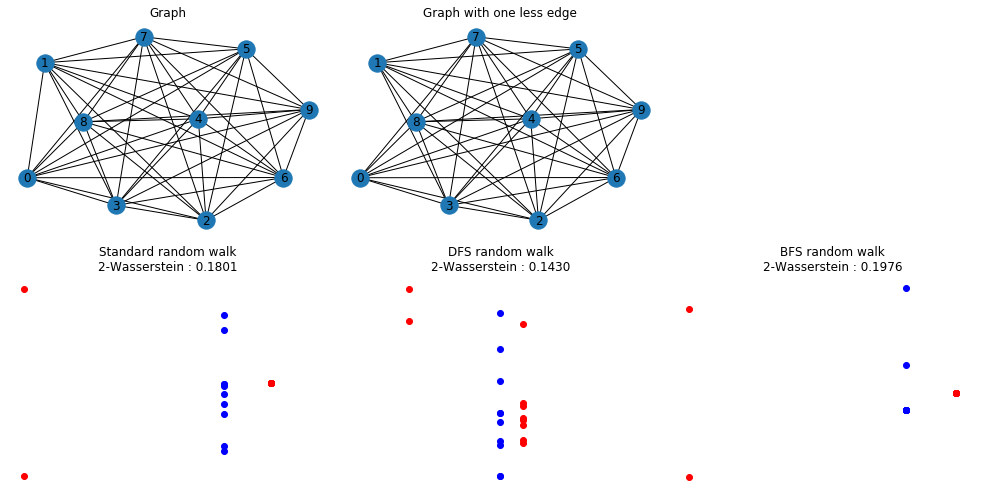

In [7]:
if USE_PCA_TO_PLOT:
    # extract 2 principal components to plot
    pca = PCA(n_components=2)
    emb_std = pca.fit_transform(emb_std)
    emb_removed_std = pca.fit_transform(emb_removed_std)
    emb_dfs = pca.fit_transform(emb_dfs)
    emb_removed_dfs = pca.fit_transform(emb_removed_dfs)
    emb_bfs = pca.fit_transform(emb_bfs)
    emb_removed_bfs = pca.fit_transform(emb_removed_bfs)
        
# plot the graph
fig, axes = plt.subplots(figsize=(14,7), nrows=2, ncols=3)

ax = axes[0, 0]
nx.draw_networkx(G, pos=pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')

ax = axes[0, 1]
nx.draw_networkx(G_removed, pos=pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

ax = axes[0, 2]
ax.axis('off')

wass_std = wasserstein_metric(emb_std, emb_removed_std)
wass_dfs = wasserstein_metric(emb_dfs, emb_removed_dfs)
wass_bfs = wasserstein_metric(emb_bfs, emb_removed_bfs)

ax = axes[1, 0]
ax.scatter(emb_std[:, 0], emb_std[:, 1], label='original', color='b')
ax.scatter(emb_removed_std[:, 0], emb_removed_std[:, 1], label='removed', color='r')
ax.set_title('Standard random walk\n2-Wasserstein : {:.4f}'.format(wass_std))
# ax.legend(loc='lower left')
ax.axis('off')

ax = axes[1, 1]
ax.scatter(emb_dfs[:, 0], emb_dfs[:, 1], label='original', color='b')
ax.scatter(emb_removed_dfs[:, 0], emb_removed_dfs[:, 1], label='removed', color='r')
ax.set_title('DFS random walk\n2-Wasserstein : {:.4f}'.format(wass_dfs))
# ax.legend(loc='lower left')
ax.axis('off')

ax = axes[1, 2]
ax.scatter(emb_bfs[:, 0], emb_bfs[:, 1], label='original', color='b')
ax.scatter(emb_removed_bfs[:, 0], emb_removed_bfs[:, 1], label='removed', color='r')
ax.set_title('BFS random walk\n2-Wasserstein : {:.4f}'.format(wass_bfs))
# ax.legend(loc='lower left')
ax.axis('off')

plt.tight_layout()
plt.show()

fig.savefig('rw_factorization_complete.eps')